In [1]:
from shapely.geometry import Polygon, Point, MultiPolygon
from shapely import intersection, intersection_all, difference, union_all, union
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as PlotPolygon
from matplotlib.patches import Rectangle
from random import random, randrange
from math import comb, dist
from itertools import combinations
import copy
from time import sleep

### Define create functions

In [2]:
## Make circle function as polygon
def Circle(x, y, radius):
    return Point(x,y).buffer(radius)


### Define process function

In [3]:
def printID(objects : list):
    for object in objects:
        print(object.id, end=", ")

In [4]:
def getIntersectRegions(polygons): ## polygons is the list of all polygon
    return_list = []

    for iteration in range (len (polygons)):
        temp_return_list = return_list
        combo_list = list(combinations(polygons, len(polygons)-iteration))
        for combo in combo_list:
            temp = intersection_all(combo)
            if not temp.is_empty:
                temp = difference(temp, union_all(temp_return_list, grid_size = 0.005), grid_size = 0.009)
            if not temp.is_empty:
                if type(temp) == MultiPolygon:
                    area_list = [poly.area for poly in temp.geoms]
                    temp = temp.geoms[area_list.index(max(area_list))]       
                return_list.append(temp)

    
    return return_list

In [5]:
def ExcludeTableRegion(regions):
    table = Polygon(((-1,-0.5),(-1, 0.5),(1, 0.5),(1,-0.5)))
    results = []
    for region in regions:
        result = difference(region, table.buffer(0.3))
        if not result.is_empty:
            if type(result) == MultiPolygon:
                for poly in result.geoms:
                    results.append(poly)
            else:
                results.append(result)
        
    return results


In [6]:
def LinkRegionAndPlate(regions: list , Plates:list): # Plates is a list of Plates, while regions are polygons    
    Regions = []
    for region in regions:
        r = Region(region)
        for plate in Plates:
            if dist(r.center, plate.center) <=1:
                r.member_plate.append(plate)
                plate.intersect_regions.append(r)
        Regions.append(r)
        
    return Regions

In [7]:
def getNearestPlate(point, plates):
    
    for (i, plate) in enumerate(plates):
        if i == 0:
            nearest = plate
            nearest_dist = dist(plate.center, point)
        else:
            distance = dist(plate.center, point)
            if distance < nearest_dist:
                nearest = plate
                nearest_dist = distance
                
    return nearest, nearest_dist

### Visualise Function

In [8]:
def randomColor():
    r = random()
    g = random()
    b = random()
    return (r,g,b)

def visualiseScene(polygons = [], points = [], table = False):
    colors = []
    fig, ax = plt.subplots(figsize = (9,6))
    ax.set_xlim([-3, 3])
    ax.set_ylim([-2, 2])
    ax.set_title('Shapely Polygons Visualization')

    # Draw polygons
    for polygon in polygons:
        if not polygon.is_empty:
        # color
            ax.add_patch(PlotPolygon(xy=polygon.exterior.coords, edgecolor='black', facecolor=randomColor(), alpha = 0.5))
        
        # grey
        # ax.add_patch(PlotPolygon(xy=polygon.exterior.coords, edgecolor='black', facecolor='black', alpha = 0.1))
    
    
    # Draw Rectangle (Table)
    if table:
        ax.add_patch(PlotPolygon(xy=Polygon(((-1,-0.5),(-1, 0.5),(1, 0.5),(1,-0.5))).exterior.coords, edgecolor='black', facecolor='white', alpha = 1))
    
    # Draw points
    for point in points:
        plt.scatter(point[0],point[1], color ="black")      
        

    plt.show()

### Load in intial test scene data

In [9]:
class Region:
    def __init__(self, poly:Polygon):
        self.poly = poly
        self.x = poly.centroid.x
        self.y = poly.centroid.y
        self.center = (self.x, self.y)
        self.area = poly.area
        self.member_plate = []

    # def __str__(self):
    #     return f"Region Center: {self.center}"
        

In [10]:
class Plate:
    def __init__(self, x=0, y=0, radius=1, id=0):
        self.id = id
        self.x = x
        self.y = y
        self.radius = radius
        self.center = (x,y)
        self.polygon = Circle(x,y,radius)
        self.intersect_regions = []

    # def __str__(self):
    #     return f"Plate ID: {self.id}, center: {self.center}"

def CreatePlateScene(coords): # coords is list of (x,y) of plate, e.g. [(1,2),(2,4),(5,1)]
    plates = []
    for (i, plate) in enumerate(coords):
        plates.append(Plate(plate[0],plate[1],1, i))

    return plates

plate_coords = [    
        (0.69136,-0.03378),
        (0.46042,-0.31386),
        (0.23854,0.22787),
        (-0.07518,-0.28684),
        (-0.20048,0.13328),
        (0.63731,0.25367),
        (0.21473,0.04484),
        (-0.69118,-0.27422),
        (-0.824,0.26879),
        (-0.39502,-0.31306),
        (-0.5668,0.13019)
        ]

plates = CreatePlateScene(plate_coords)

# for plate in plates:
#     print (f"x = {plate.x}")
#     print (f"y = {plate.y}")
#     print (f"center = {plate.center}")
#     print()  

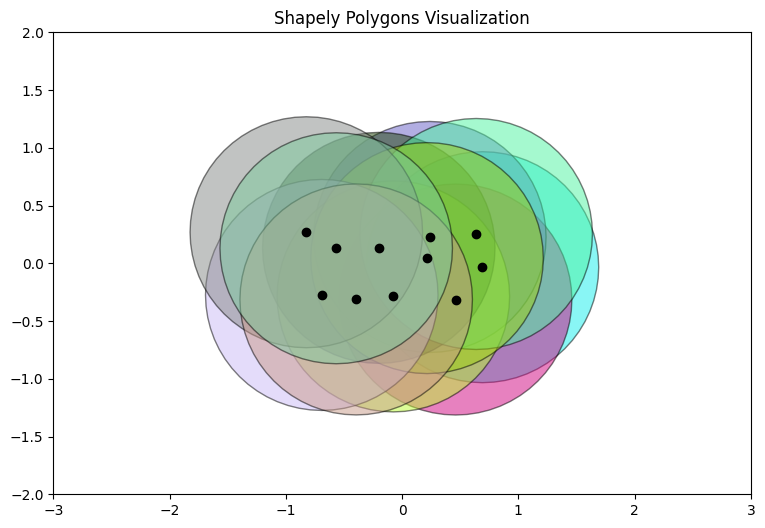

In [11]:
poly_list = [plate.polygon for plate in plates]
centers_list = [plate.center for plate in plates]
visualiseScene(poly_list, centers_list)

### 1. Get all the overlapping region as a possible node 

In [12]:
x = getIntersectRegions(poly_list)
z = ExcludeTableRegion(x)


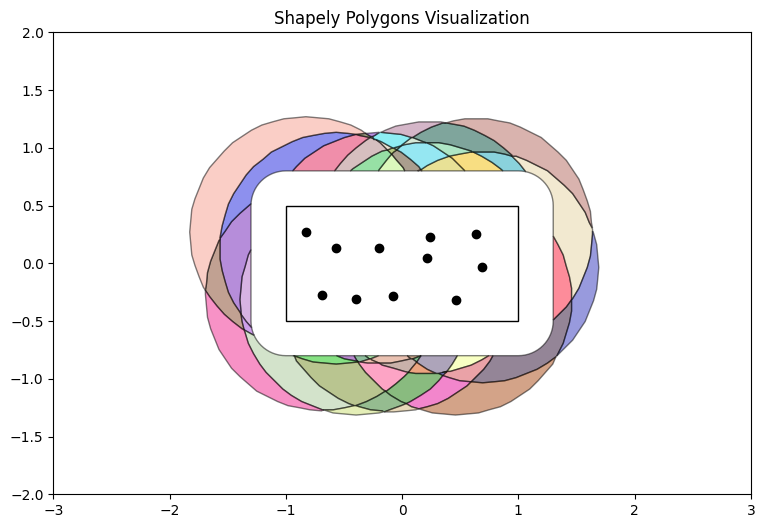

In [13]:
visualiseScene(z,centers_list,table=True)

In [14]:
Z = LinkRegionAndPlate(z, plates)

### 2. Search for first node 
#### a. From start select nearest plate

In [15]:
start_point = (0.0,-1.5)

Nearest Plate id       : 3
Nearest Plate Center   : (-0.07518, -0.28684)
Nearest distance       : 1.2154872348157344


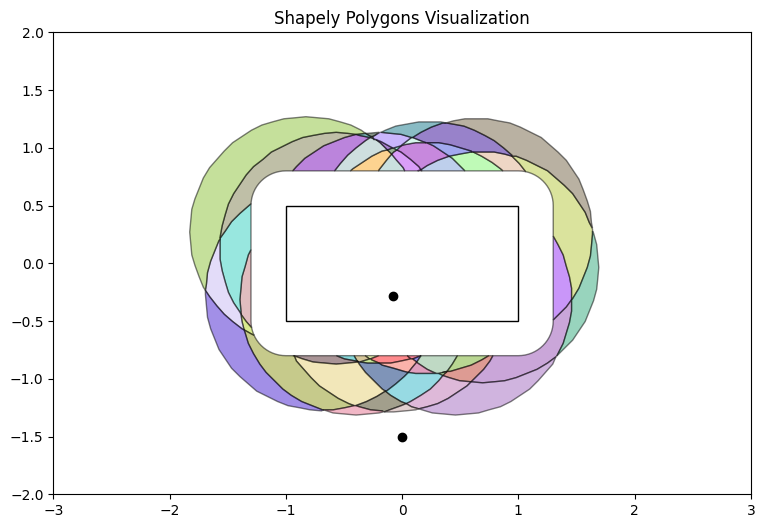

In [16]:
n1, d1 = getNearestPlate(start_point, plates)
print (f'Nearest Plate id       : {n1.id}')
print (f'Nearest Plate Center   : {n1.center}')
print (f'Nearest distance       : {d1}')
visualiseScene(polygons=z,points=[start_point, n1.center], table=True)

#### b. Get the region linked to the current plate and has most link to other plates

In [17]:
def getBestRegion(plate:Plate):
    n = 0
    for (i, region) in enumerate(plate.intersect_regions):
        if i == n:
            if region.area < 0.01:
                n+=1
                continue
            max_plate_region = region
            max_plate_qty = len(region.member_plate)
            
        else:
            plate_qty = len(region.member_plate)
            if plate_qty > max_plate_qty  and region.area >= 0.01:
                max_plate_region = region
                max_plate_qty = len(region.member_plate) 
    
    return copy.deepcopy(max_plate_region), max_plate_qty, max_plate_region.area

In [18]:
best_region, best_region_qty, best_region_area = getBestRegion(n1)

print(f"Max Plate Region Center :{best_region.center}")
print(f"Max Plate Quantity      :{best_region_qty}")
print(f"Max Plate Region Area   :{best_region_area}")



Max Plate Region Center :(-0.10481757705218195, -0.8287369341877734)
Max Plate Quantity      :6
Max Plate Region Area   :0.01638499999999999


In [19]:
best_region_plates = [plate.center for plate in best_region.member_plate]

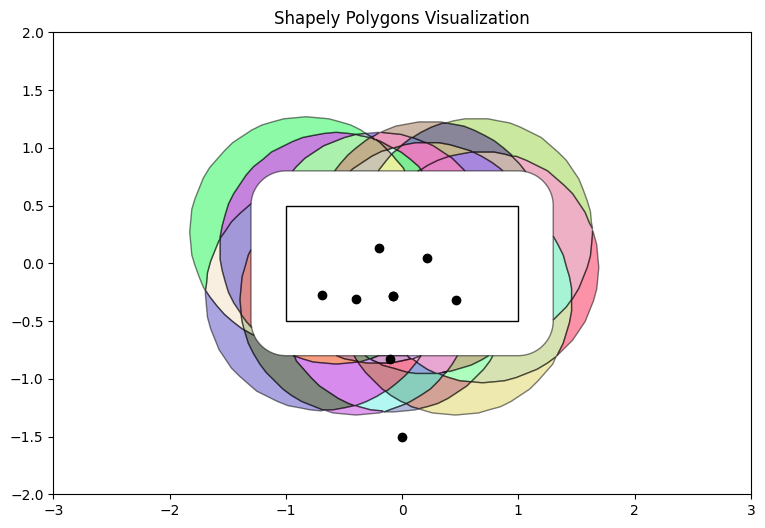

In [20]:
# visualiseScene(points=das, table=True)
visualiseScene(polygons = [best_region.poly]+z ,points = [best_region.center, start_point, n1.center] + best_region_plates, table=True)

In [21]:
for plate in best_region.member_plate:
    print(plate.id)
    print(plate)

1
3
4
6
7
9


#### c. Update all regions by removing the covered plate (only remaining plates left)

In [22]:
for plate in best_region.member_plate:
    print(plate.id)
    print (plate)

1
3
4
6
7
9


In [23]:
def updateRegions(regions, plates):

    plate_ids = [plate.id for plate in plates]

    for region in regions:

        for mem_plate in [i for i in region.member_plate]:

            if mem_plate.id in plate_ids:

                region.member_plate.remove(mem_plate)


updateRegions(Z, best_region.member_plate)


In [24]:
for region in Z:
    for plate in region.member_plate:
        print(plate.id, end=", ")
    print()

0, 
10, 
0, 
0, 
0, 2, 5, 10, 

10, 
2, 5, 8, 10, 
0, 
0, 2, 5, 


2, 5, 10, 
2, 8, 10, 
10, 
0, 
0, 
0, 2, 5, 


2, 5, 
2, 10, 
2, 8, 10, 
10, 
8, 10, 
0, 
0, 5, 
0, 
0, 2, 5, 

2, 5, 
2, 
2, 8, 
2, 10, 
2, 5, 

8, 10, 
8, 
8, 10, 
0, 
0, 5, 

2, 
2, 5, 

8, 
8, 

8, 10, 
0, 

2, 


5, 

8, 



In [25]:
plates_remain = [plate for plate in plates if plate.id not in [plate.id for plate in best_region.member_plate]]
printID(plates_remain)

0, 2, 5, 8, 10, 

### 3. Repeat until no plate remain

#### a. 2nd Iteration

In [26]:
n2,d2 = getNearestPlate(best_region.center, plates_remain)
print(n2,"\n",d2)

 1.0644099887841616


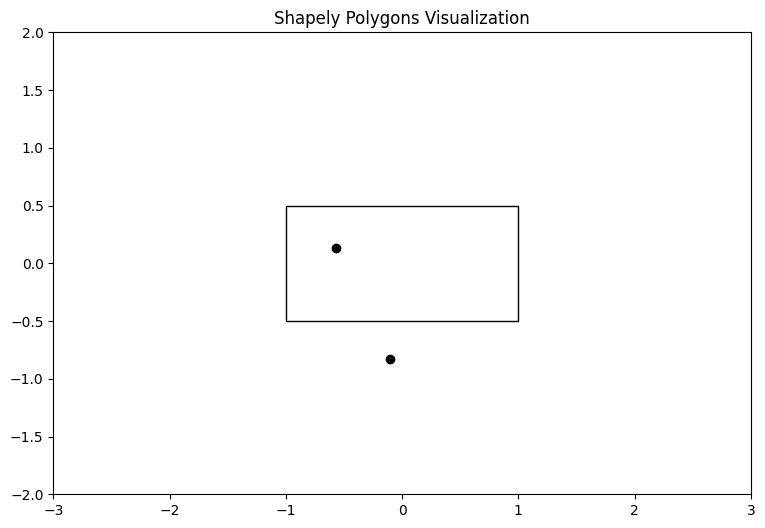

In [27]:
visualiseScene(points=[n2.center , best_region.center], table = True)

In [37]:
best_region_2, best_region_2_qty, best_region_2_area =  getBestRegion(n2)

In [39]:
printID(best_region_2.member_plate)

2, 5, 8, 10, 

In [40]:
updateRegions(Z, best_region_2.member_plate)

In [45]:
plates_remain = [plate for plate in plates_remain if plate.id not in [plate.id for plate in best_region_2.member_plate]]

#### b. 3rd Iteration

In [48]:
n3, d3 = getNearestPlate(best_region_2.center, plates_remain)
best_region_3, best_region_3_qty, best_region_3_area =  getBestRegion(n3)
printID(best_region_3.member_plate)
updateRegions(Z, best_region_3.member_plate)
plates_remain = [plate for plate in plates_remain if plate.id not in [plate.id for plate in best_region_3.member_plate]]

0, 

In [49]:
plates_remain


[]